In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
import re
import seaborn as sns
import operator
from gensim.models.word2vec import Word2Vec

%matplotlib inline

In [2]:
def restore_tokens_from_text(text):
    """
        由于Excel里读取出来的数据都是string类型,这里我们把文本转换成list.
    """
    regex_to_list = r"[\[\',\]\(\)）（]"
    space_separated_string = re.sub(regex_to_list, '', text)
    return space_separated_string.split(' ')

In [3]:
training_path = '/home/alvin/!Final_Project/training_with_tokens.xlsx'
testing_path = '/home/alvin/!Final_Project/testing_with_tokens.xlsx'

df_train = pd.read_excel(training_path, names=['class', 'descriptions', 'baidu_tokens', 'jieba_tokens', 'merged_tokens'])

In [4]:
df_train['tokens'] = df_train['merged_tokens'].apply(restore_tokens_from_text)

In [5]:
df_kmeans = df_train[['class', 'tokens']]
df_kmeans['token_count'] = df_kmeans['tokens'].apply(len)

/home/alvin/.conda/envs/tf-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [6]:
df_kmeans.head()

,class,tokens,token_count
0,2,"[合晟资产, 专注, 股票, 债券, 二级市场, 投资, 合格, 投资者, 资产, 管理, ...",46
1,2,"[中, 小微企业, 个体, 工商户, 农户, 贷款, 设立, 发生, 变化]",9
2,1,"[立足于, 商业地产, 商业地产, 开发, 销售, 运营, 全产业链, 一整套, 增值, 业...",47
3,2,"[工商管理部门, 核准, 经营范围, 投资, 咨询, 经济, 信息, 咨询, 企业管理, 咨...",47
4,2,"[中国, 境内, 港, 澳, 台, 保险代理, 销售, 研究, 能力, 专业化, 能力, 团...",48


In [7]:
df_kmeans['token_count'].describe()

count    4774.000000
mean       70.170297
std        53.281500
min         1.000000
25%        36.250000
50%        57.000000
75%        88.000000
max       598.000000
Name: token_count, dtype: float64

/home/alvin/.conda/envs/tf-gpu/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


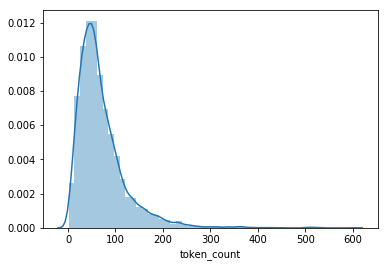

In [8]:
sns.distplot(df_kmeans['token_count'])

In [9]:
def convert_tokens_to_sentence(tokens):
    return ' '.join(tokens)

df_kmeans['sentence'] = df_kmeans['tokens'].apply(convert_tokens_to_sentence)

/home/alvin/.conda/envs/tf-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [10]:
df_kmeans.head()

,class,tokens,token_count,sentence
0,2,"[合晟资产, 专注, 股票, 债券, 二级市场, 投资, 合格, 投资者, 资产, 管理, ...",46,合晟资产 专注 股票 债券 二级市场 投资 合格 投资者 资产 管理 企业 业务范围 资产 ...
1,2,"[中, 小微企业, 个体, 工商户, 农户, 贷款, 设立, 发生, 变化]",9,中 小微企业 个体 工商户 农户 贷款 设立 发生 变化
2,1,"[立足于, 商业地产, 商业地产, 开发, 销售, 运营, 全产业链, 一整套, 增值, 业...",47,立足于 商业地产 商业地产 开发 销售 运营 全产业链 一整套 增值 业务 覆盖 商业 定位...
3,2,"[工商管理部门, 核准, 经营范围, 投资, 咨询, 经济, 信息, 咨询, 企业管理, 咨...",47,工商管理部门 核准 经营范围 投资 咨询 经济 信息 咨询 企业管理 咨询 品牌 推广 策划...
4,2,"[中国, 境内, 港, 澳, 台, 保险代理, 销售, 研究, 能力, 专业化, 能力, 团...",48,中国 境内 港 澳 台 保险代理 销售 研究 能力 专业化 能力 团体 个人保险 受众 投保...


In [11]:
text = df_kmeans['sentence'].tolist()
text

['合晟资产 专注 股票 债券 二级市场 投资 合格 投资者 资产 管理 企业 业务范围 资产 管理 投资 咨询 投资 顾问 管理 私募基金 股票型 债券型 资产 管理 计划 证券投资 基金 管理 总资产 规模 80亿元 中国证券投资基金业协会 数据 管理 私募证券投资基金 顾问 管理 类 规模 较大 管理 规模 处于 50亿元 第一 梯队',
 '中 小微企业 个体 工商户 农户 贷款 设立 发生 变化',
 '立足于 商业地产 商业地产 开发 销售 运营 全产业链 一整套 增值 业务 覆盖 商业 定位 策划 商业 设计 销售代理 招商 代理 电子商务 商业地产 运管 互联网 电商 模式 O2O 线上 导流 线下服务 方式 住宅类 业务 创新 营销 业务 板块 商业地产 策划 顾问 招商 运营 管理 代理 销售 麦吉铺 O2O 电子商务',
 '工商管理部门 核准 经营范围 投资 咨询 经济 信息 咨询 企业管理 咨询 品牌 推广 策划 公共关系策划 文化交流 策划 咨询 企业形象 策划 图文 设计 会展 依法 须经 批准 项目 部门 批准 后方 经营 活动 国内 上市公司 投资者 关系 顾问 国民经济行业分类 GBT 4754 2011 商务 服务业 L72 分类 社会经济 咨询 L7233',
 '中国 境内 港 澳 台 保险代理 销售 研究 能力 专业化 能力 团体 个人保险 受众 投保 需求分析 投保 方案 制定 保险理赔 保单 保全 一站式 最终 保险公司 人身保险 财产保险 保险产品 代理 销售 综合 成立 中国人民人寿保险股份有限公司 中德安联人寿保险有限公司 中英人寿保险有限公司 阳光人寿保险股份有限公司 中意人寿保险有限公司 同方全球人寿保险有限公司 中国泰康人寿保险股份有限公司 数十家 保险公司 紧密 合作关系 为其 千余种 保险产品 代理 销售',
 '地铁 商业物业 租赁 运营 管理 整体 租赁 方式 轨道交通 站点 附属 建筑物 商业物业 经营权 利用 承租 物业 商铺 出租 运营 管理 承租 物业 规划 定位 设计 改造 商业 业态 经营 消费者 需求 提升 商业价值 空间 更优 租金 收益 2015年 2014年 经审计 营业收入 21 740 629.29元 550 498.50元 主营业务收入 占 营业收入 比重 100% 设立 

In [12]:
vectorizer = TfidfVectorizer()
vectorizer.fit(text)

print(vectorizer.vocabulary_)
print(vectorizer.idf_)

{'合晟资产': 13986, '专注': 6594, '股票': 32213, '债券': 9931, '二级市场': 8175, '投资': 20472, '合格': 13987, '投资者': 20480, '资产': 34758, '管理': 30475, '企业': 9051, '业务范围': 6698, '咨询': 14350, '顾问': 38245, '私募基金': 29708, '股票型': 32215, '债券型': 9932, '计划': 34094, '证券投资': 34239, '基金': 15624, '总资产': 19731, '规模': 34008, '80亿元': 3075, '中国证券投资基金业协会': 7373, '数据': 21630, '私募证券投资基金': 29718, '较大': 35357, '处于': 15838, '50亿元': 2355, '第一': 30271, '梯队': 23828, '小微企业': 17705, '个体': 6889, '工商户': 18154, '农户': 10929, '贷款': 34743, '设立': 34209, '发生': 13594, '变化': 13685, '立足于': 30118, '商业地产': 14485, '开发': 19098, '销售': 37047, '运营': 35585, '全产业链': 10265, '一整套': 5851, '增值': 15762, '业务': 6684, '覆盖': 33959, '商业': 14476, '定位': 17186, '策划': 30401, '设计': 34211, '销售代理': 37051, '招商': 20729, '代理': 8917, '电子商务': 28147, '运管': 35580, '互联网': 8331, '电商': 28104, '模式': 23968, 'o2o': 4943, '线上': 31078, '导流': 17597, '线下服务': 31082, '方式': 22073, '住宅类': 9394, '创新': 11507, '营销': 33320, '板块': 23416, '麦吉铺': 39115, '工商管理部门': 18156, '核准': 23691, '经营范围': 31

In [13]:
'中' in vectorizer.vocabulary_

False

In [14]:
features = vectorizer.get_feature_names()
len(features)

39293

In [15]:
vector = vectorizer.transform(text)
print(vector.shape)

(4774, 39293)


In [16]:
def top_features_in_doc(Xtr, features, row_id, top_n=25):
    row = np.squeeze(Xtr[row_id].toarray())
    tokens = df_kmeans.loc[row_id]['tokens']
    token_length = len(tokens)
#     print('Token length: ', str(token_length))
    token_values = {}
    for i in range(token_length):
        # Get tfidf score for each token
        token_name = tokens[i]
        try:
            if token_name in vectorizer.vocabulary_:
                token_index = vectorizer.vocabulary_[token_name]
                token_value = row[token_index]
            else:
                token_value = 0
        except:
            print("Exception: ", str(row_id))
        token_values[token_name] = token_value
    # Sort the tokens by tfidf values
    sorted_tokens = sorted(token_values.items(), key=operator.itemgetter(1), reverse=True)
#     print(sorted_tokens)
    # Get the most weighted tokens
    top_tokens = []
    padding_count = 0
#     print("Sorted tokens length: ", str(len(sorted_tokens)))
    if len(sorted_tokens) < top_n:
        padding_count = top_n - len(sorted_tokens)
        for i in range(len(sorted_tokens)):
            top_tokens.append(sorted_tokens[i][0])
    else:
        for i in range(top_n):
            top_tokens.append(sorted_tokens[i][0])
    for i in range(padding_count):
        top_tokens.append('UNKNOWN')
    return top_tokens

In [17]:
row_index = 61
print(df_kmeans.loc[row_index]['tokens'])
top_features_in_doc(vector, features, row_index, 10)

['子公司', '融资', '租赁', '业务', '典当业务', '投资', '管理', '业务', '委托贷款业务']


['典当业务', '委托贷款业务', '融资', '租赁', '业务', '投资', '子公司', '管理', 'UNKNOWN', 'UNKNOWN']

In [18]:
type(int(df_kmeans.loc[0].name))

int

In [117]:
df_kmeans['top_10_tokens'] = df_kmeans.apply(lambda x: top_features_in_doc(vector, features, x.name, 32), axis=1)
# df_kmeans['top_10_tokens'] = df_kmeans.apply(lambda x: print(x.name), axis=1)

In [118]:
df_kmeans[['tokens', 'sentence', 'top_10_tokens']].head()

,tokens,sentence,top_10_tokens
0,"[合晟资产, 专注, 股票, 债券, 二级市场, 投资, 合格, 投资者, 资产, 管理, ...",合晟资产 专注 股票 债券 二级市场 投资 合格 投资者 资产 管理 企业 业务范围 资产 ...,"[管理, 资产, 规模, 投资, 顾问, 合晟资产, 股票型, 债券型, 80亿元, 中国证..."
1,"[中, 小微企业, 个体, 工商户, 农户, 贷款, 设立, 发生, 变化]",中 小微企业 个体 工商户 农户 贷款 设立 发生 变化,"[工商户, 个体, 小微企业, 贷款, 农户, 设立, 变化, 发生, 中, UNKNOWN..."
2,"[立足于, 商业地产, 商业地产, 开发, 销售, 运营, 全产业链, 一整套, 增值, 业...",立足于 商业地产 商业地产 开发 销售 运营 全产业链 一整套 增值 业务 覆盖 商业 定位...,"[商业地产, 招商, 电子商务, 商业, 运管, 住宅类, 麦吉铺, 策划, 导流, 线下服..."
3,"[工商管理部门, 核准, 经营范围, 投资, 咨询, 经济, 信息, 咨询, 企业管理, 咨...",工商管理部门 核准 经营范围 投资 咨询 经济 信息 咨询 企业管理 咨询 品牌 推广 策划...,"[咨询, 策划, 公共关系策划, 社会经济, 文化交流, 工商管理部门, 投资者, 批准, ..."
4,"[中国, 境内, 港, 澳, 台, 保险代理, 销售, 研究, 能力, 专业化, 能力, 团...",中国 境内 港 澳 台 保险代理 销售 研究 能力 专业化 能力 团体 个人保险 受众 投保...,"[投保, 保险产品, 保险公司, 个人保险, 人身保险, 中国人民人寿保险股份有限公司, 中..."


In [119]:
w2v_model = Word2Vec.load('w2v_model.w2v')

In [75]:
np.zeros(10, dtype=int).tolist()

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [37]:
w2v_model['顾问']

/home/alvin/.conda/envs/tf-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 0.20951226,  0.11384013, -0.11177708,  0.04628611, -0.19558701,
       -0.01377099, -0.23937128,  0.4224005 , -0.5438636 , -0.22734857,
        0.11438831,  0.46960968, -0.31623417,  0.01652195,  0.0189079 ,
       -0.04183276,  0.00898955, -0.34244508, -0.0731507 , -0.26599446,
       -0.04606455,  0.27138704,  0.00814371,  0.23252314, -0.06029655,
        0.47684118, -0.1262999 ,  0.24777348, -0.06721571, -0.234324  ,
       -0.22080225, -0.46661454,  0.3974383 ,  0.03398783, -0.1461924 ,
       -0.04599177,  0.21584745,  0.37525964,  0.02835915, -0.27217254,
        0.08769832, -0.00363356, -0.09293603, -0.04900242,  0.19713046,
        0.5339736 , -0.28898832, -0.6366817 , -0.38356608,  0.5377308 ,
        0.36867732,  0.1096022 , -0.02327889, -0.27265146, -0.05481065,
        0.24581948, -0.20430744, -0.09160402, -0.11282106, -0.12734039,
       -0.34885278, -0.3872848 , -0.26147074,  0.12887406,  0.2957204 ,
        0.18981253,  0.22389439, -0.31015012, -0.02105393, -0.32

In [120]:
default_embedding = np.zeros(128, dtype=int).tolist()
def convert_tokens_to_features(tokens):
    features = []
    for t in tokens:
        if t in w2v_model:
            features += w2v_model[t].tolist()
        else:
            features += default_embedding
    return features

In [121]:
df_kmeans['features'] = df_kmeans['top_10_tokens'].apply(convert_tokens_to_features)

/home/alvin/.conda/envs/tf-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  """
/home/alvin/.conda/envs/tf-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [122]:
len(df_kmeans.loc[0]['features'])

4096

In [123]:
km = KMeans(n_clusters=11, init='k-means++', max_iter=100, n_init=1)

In [124]:
km.fit(df_kmeans['features'].tolist())

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=11, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [80]:
import collections

In [125]:
results = km.predict(df_kmeans[df_kmeans['class']==4]['features'].tolist())

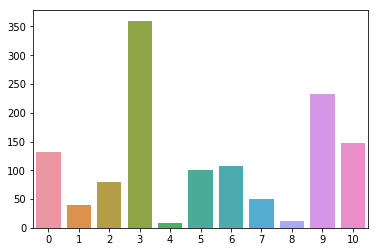

In [126]:
word_counters = collections.Counter(results)
sns.barplot(x=list(word_counters.keys()), y=list(word_counters.values()))

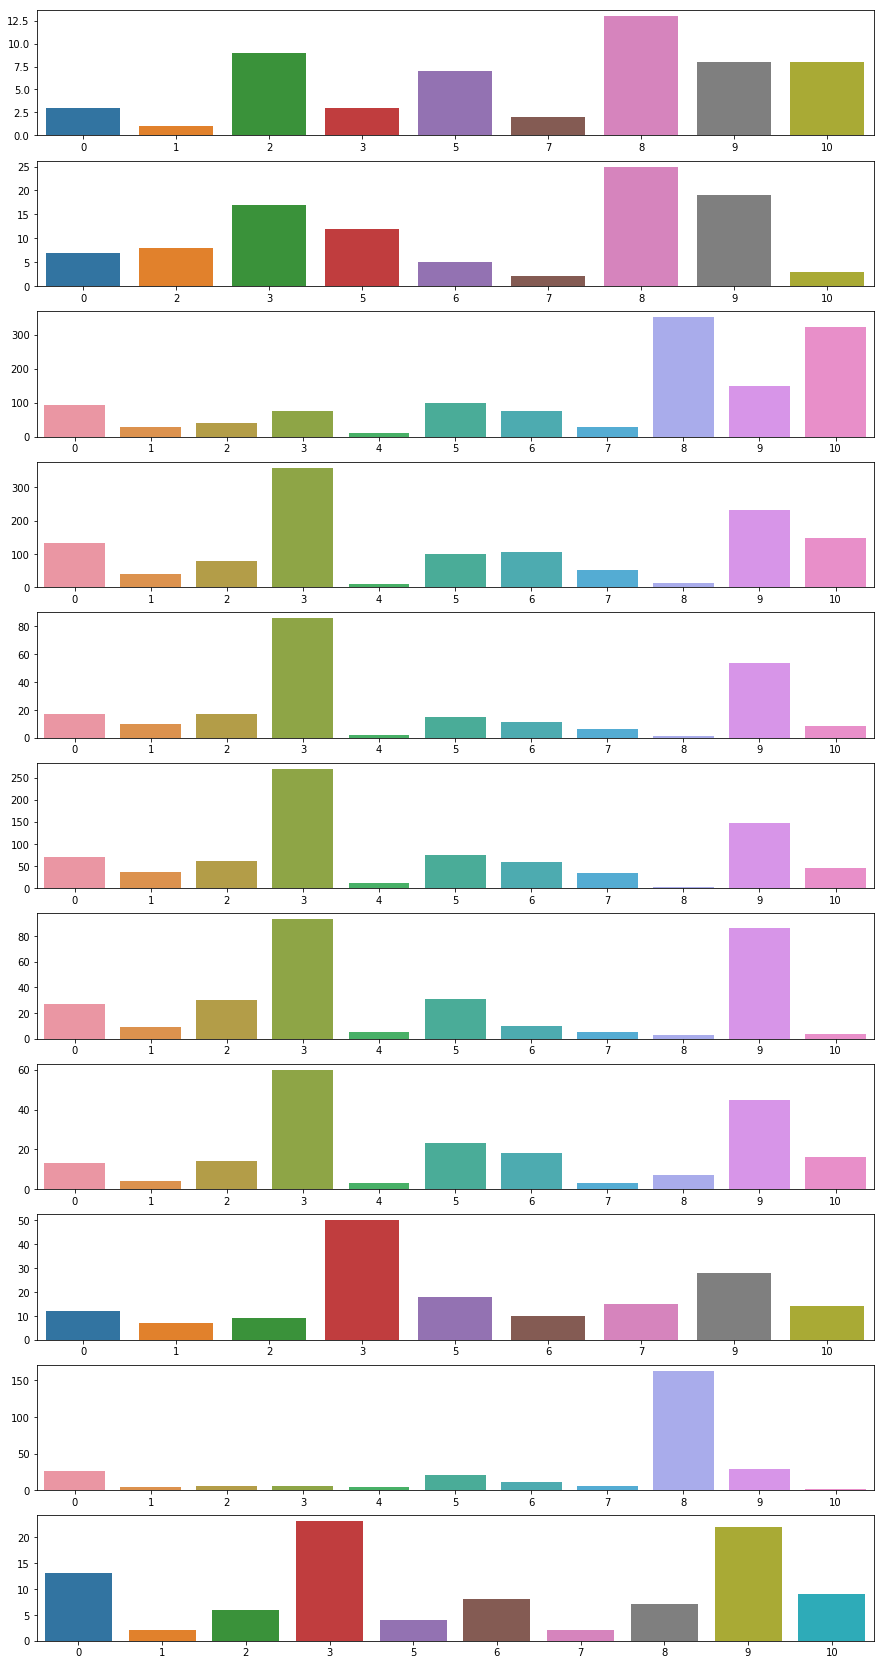

In [127]:
plt.figure(figsize=(15, 30))
for i in range(1, 12):
    results = km.predict(df_kmeans[df_kmeans['class']==i]['features'].tolist())
    word_counters = collections.Counter(results)
    plt.subplot(11, 1, i)
    sns.barplot(x=list(word_counters.keys()), y=list(word_counters.values()))

In [128]:
df_kmeans['predicted'] = km.predict(df_kmeans['features'].tolist())

In [131]:
df_kmeans[['class', 'predicted', 'top_10_tokens']].to_csv('predicted.csv')